In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from darkgreybox.model import Ti

2020-10-13 11:17:18,085 darkgreybox  INFO     Logging enabled...


## Demo Notebook 01 - Ti Model Direct Fit

This notebook demonstrates the direct usage of the `DarkGreyBox` models via a simple fitting example for a `Ti` model.


Our temporal resolution is 1 hour

In [2]:
# the duration of a record
rec_duration = 1 # hour

Read some demo data.  
* Ph: Heating system power output
* Ta: Ambient temperature
* Ti: Internal temperature

Note: This demo data is intentionally far from ideal and particularly challenging to model with low errors. It is taken from a building where there are many factors influencing the heat dynamics of the building that are not accounted for in the modelling (solar gains, passive gains, hot water demand, gas use in the canteen etc.). The time period is relatively short to maintain a reasonable solution time for the demo. However, it includes an also challenging holiday period when the heating system is shut down.

In [28]:
train_df = pd.read_csv('./data/demo_data.csv', index_col=0, parse_dates=True)

input_X = train_df[['Ph', 'Ta']]
input_y = train_df['Ti']

print(f'Input X shape: {input_X.shape}, input y shape: {input_y.shape}')

Input X shape: (792, 2), input y shape: (792,)


Use the `sklearn.model_selection.train_test_split` function to split the input data into train and test data. (Input data is 33 days long and 5 days of test data is specified)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=5 / 33, shuffle=False)

print(f'Train: X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test: X shape: {X_test.shape}, y shape: {y_test.shape}')

Train: X shape: (672, 2), y shape: (672,)
Test: X shape: (120, 2), y shape: (120,)


Set up the model training parameters.  

The `Ti0` param is the initial condition for the internal temperature at t=0 - this is set to the first value in `y_train` and is fixed, hence `vary: False`.  

`Ci` and `Ria` params are the initial conditions for these thermal parameters. As these will be fit by the model training their default is `vary: True`. The values for these params' initial conditions are set arbitrarily to `1` it is assumed that no estimates have been calculated for them (e.g. based on building physical properties).


In [13]:
train_params = {
    'Ti0': {'value': y_train.iloc[0], 'vary': False},
    'Ci': {'value': 1},
    'Ria': {'value': 1},
}

Instantiate the `Ti` model and fit to the training data using the least-squares method.

In [24]:
model = Ti(params=train_params, rec_duration=rec_duration) \
            .fit(X=X_train, y=y_train, method='leastsq')

Display the result of the fit: `Ci` and `Ria` params have been fit and their errors are calculated.

In [25]:
model.result.params

name,value,standard error,relative error,initial value,min,max,vary
Ti0,18.1375000,0.00000000,(0.00%),18.1375,-inf,inf,False
Ci,448.100059,10.0047632,(2.23%),1,-inf,inf,True
Ria,0.63657594,0.00334177,(0.52%),1,-inf,inf,True


Get the training results by calling `predict` for the training data

In [19]:
train_results = model.predict(X=X_train)

Plot the modelled and measured data for the train set.  

Unsurprisingly, a model with such low complexity can only follow the general trend but it has high errors.

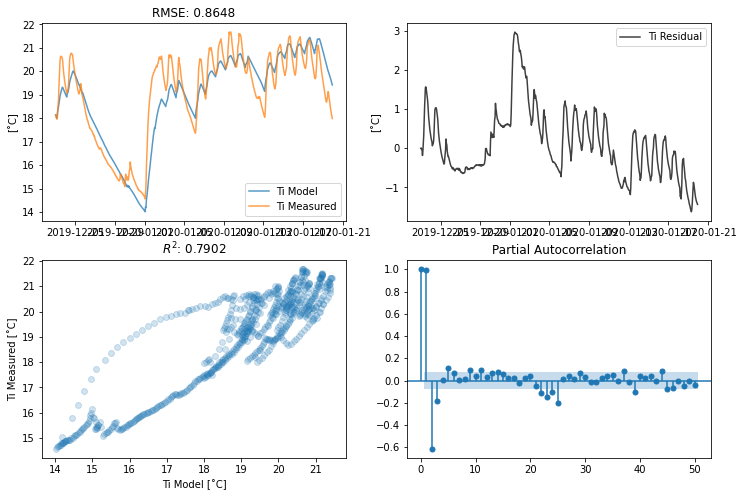

In [20]:
rmse = mean_squared_error(y_train, train_results.Z) ** 0.5
r2 = r2_score(y_train, train_results.Z)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(y_train.index, train_results.Z, label='Ti Model', alpha=0.75)
ax[0, 0].plot(y_train, label='Ti Measured', alpha=0.75)
ax[0, 0].legend()
ax[0, 0].set_ylabel('[˚C]')
ax[0, 0].set_title(f'RMSE: {rmse:.4f}')

ax[1, 0].scatter(train_results.Z, y_train, alpha=0.2)
ax[1, 0].set_xlabel('Ti Model [˚C]')
ax[1, 0].set_ylabel('Ti Measured [˚C]')
ax[1, 0].set_title(f'$R^2$: {r2:.4f}')

ax[0, 1].plot(y_train.index, y_train - train_results.Z, label='Ti Residual', color='black', alpha=0.75)
ax[0, 1].legend()
ax[0, 1].set_ylabel('[˚C]')

plot_pacf(y_train - train_results.Z, ax=ax[1, 1], lags=50);


To get the test results, the model takes `X_test` as the input data. Also, as the initial condition for the internal temperature at t=0 is different at the start of the test data to what the model params currently holds (which is the internal temperature at t=0 of the *training data*), we need to update that variable.

In [21]:
test_results = model.predict(X=X_test, ic_params={'Ti0': y_test.iloc[0]})

Plot the modelled and measured data for the test set.  

As expected, the simple `Ti` model cannot generalise well enough to perform well on data it has not seen before.

/Users/quarentine/.virtualenvs/darkgreybox/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


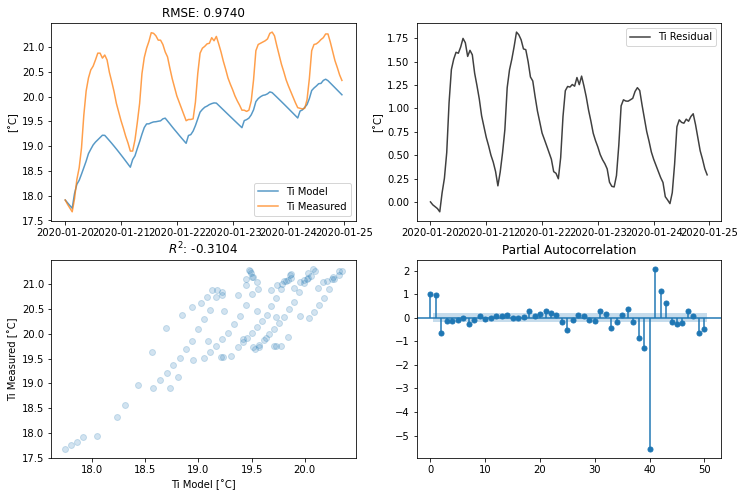

In [22]:
rmse = mean_squared_error(y_test, test_results.Z) ** 0.5
r2 = r2_score(y_test, test_results.Z)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(y_test.index, test_results.Z, label='Ti Model', alpha=0.75)
ax[0, 0].plot(y_test, label='Ti Measured', alpha=0.75)
ax[0, 0].legend()
ax[0, 0].set_ylabel('[˚C]')
ax[0, 0].set_title(f'RMSE: {rmse:.4f}')

ax[1, 0].scatter(test_results.Z, y_test, alpha=0.2)
ax[1, 0].set_xlabel('Ti Model [˚C]')
ax[1, 0].set_ylabel('Ti Measured [˚C]')
ax[1, 0].set_title(f'$R^2$: {r2:.4f}')

ax[0, 1].plot(y_test.index, y_test - test_results.Z, label='Ti Residual', color='black', alpha=0.75)
ax[0, 1].legend()
ax[0, 1].set_ylabel('[˚C]')

plot_pacf(y_test - test_results.Z, ax=ax[1, 1], lags=50);
